In [1]:
from main import *

RDKit WARNING: [17:32:44] Enabling RDKit 2019.09.1 jupyter extensions


In [44]:
LS = load_from_csv("data/training_set.csv")
TS = load_from_csv("data/test_set.csv")

# Create fingerprint features and output
with measure_time("Creating fingerprint"):
    X_LS = create_fingerprints(LS["SMILES"].values)
y_LS = LS["ACTIVE"].values
with measure_time("Creating fingerprint"):
    X_TS = create_fingerprints(TS["SMILES"].values)

Creating fingerprint...
Duration of [Creating fingerprint]: 0:00:15.553511
Creating fingerprint...
Duration of [Creating fingerprint]: 0:00:09.267629


In [45]:
#X_LS_learning, X_LS_testing, y_LS_learning, y_LS_testing = train_test_split(X_LS, y_LS, test_size=0.3, random_state=40)
from sklearn.utils import shuffle
X_LS, y_LS = shuffle(X_LS, y_LS)

In [46]:
"""from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif

nFeatures = 123
bestfeatures = SelectKBest(score_func=chi2, k=nFeatures)
#X_LS_learning, X_LS_testing, y_LS_learning, y_LS_testing = train_test_split(X_LS, y_LS, test_size=0.3, random_state=40)
fit = bestfeatures.fit(X_LS,y_LS)


featureScores = pd.DataFrame(fit.scores_)
featureScores.columns = ['Score']  #naming the dataframe columns

print(featureScores.nlargest(nFeatures,'Score'))
print(featureScores.nlargest(nFeatures,'Score').index.values)
#X_LS_learning = X_LS_learning[:,featureScores.nlargest(nFeatures,'Score').index.values]
#X_LS_testing = X_LS_testing[:,featureScores.nlargest(nFeatures,'Score').index.values]
X_LS = X_LS[:,featureScores.nlargest(nFeatures,'Score').index.values]
X_TS = X_TS[:,featureScores.nlargest(nFeatures,'Score').index.values]
#print(X_LS_learning)"""


"from sklearn.feature_selection import SelectKBest\nfrom sklearn.feature_selection import chi2, f_classif\n\nnFeatures = 123\nbestfeatures = SelectKBest(score_func=chi2, k=nFeatures)\n#X_LS_learning, X_LS_testing, y_LS_learning, y_LS_testing = train_test_split(X_LS, y_LS, test_size=0.3, random_state=40)\nfit = bestfeatures.fit(X_LS,y_LS)\n\n\nfeatureScores = pd.DataFrame(fit.scores_)\nfeatureScores.columns = ['Score']  #naming the dataframe columns\n\nprint(featureScores.nlargest(nFeatures,'Score'))\nprint(featureScores.nlargest(nFeatures,'Score').index.values)\n#X_LS_learning = X_LS_learning[:,featureScores.nlargest(nFeatures,'Score').index.values]\n#X_LS_testing = X_LS_testing[:,featureScores.nlargest(nFeatures,'Score').index.values]\nX_LS = X_LS[:,featureScores.nlargest(nFeatures,'Score').index.values]\nX_TS = X_TS[:,featureScores.nlargest(nFeatures,'Score').index.values]\n#print(X_LS_learning)"

In [4]:
"""from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X_LS,y_LS)
#print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_)
feat_importances.nlargest(30).plot(kind='barh')
plt.show()"""

"from sklearn.ensemble import ExtraTreesClassifier\nimport matplotlib.pyplot as plt\nmodel = ExtraTreesClassifier()\nmodel.fit(X_LS,y_LS)\n#print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers\n#plot graph of feature importances for better visualization\nfeat_importances = pd.Series(model.feature_importances_)\nfeat_importances.nlargest(30).plot(kind='barh')\nplt.show()"

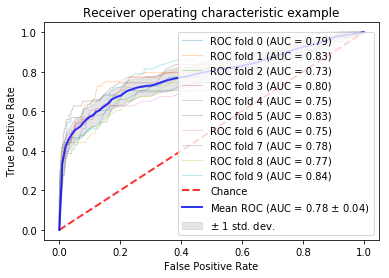

In [64]:
import numpy as np
from scipy import interp
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

# #############################################################################
# Classification and ROC analysis

#KNN
#k = 2 -> 69 +-2
#k = 3 -> 71 +-1
#k = 4 -> 72 +-2
#k = 5 -> 73 +-2
#k = 9 -> 75 +-2
#k = 14 -> 75 +-1

#k = 14 features = 120 -> 76 +-2
#k = 14 features = 115 -> 76 +-1
#k = 14 features = 110 -> 76 +-2

#RandomForest
#n_estimators = 100 -> 78 +-2
#n_estimators = 500 -> 78 +-1

# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=10, shuffle = True)
classifier = RandomForestClassifier(n_estimators=500, bootstrap=False)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

i = 0
for train, test in cv.split(X_LS, y_LS):
    probas_ = classifier.fit(X_LS[train], y_LS[train]).predict_proba(X_LS[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y_LS[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [65]:

model = RandomForestClassifier(n_estimators=500, bootstrap=False)
model = model.fit(X_LS, y_LS)

C:\Users\robin\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\robin\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\robin\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\robin\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, Converge

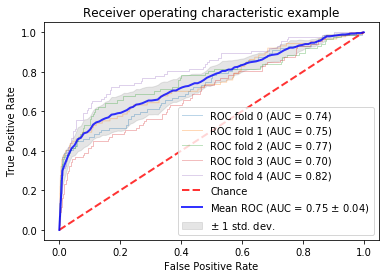

In [84]:
import numpy as np
from scipy import interp
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

# #############################################################################
# Classification and ROC analysis

# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=5, shuffle=True)
classifier = MLPClassifier(activation='tanh', hidden_layer_sizes=(500), alpha=0.05)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

i = 0
for train, test in cv.split(X_LS, y_LS):
    probas_ = classifier.fit(X_LS[train], y_LS[train]).predict_proba(X_LS[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y_LS[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [72]:
from sklearn.neural_network import MLPClassifier
model = MLPClassifier(activation='tanh', hidden_layer_sizes=(500))
model = model.fit(X_LS_learning, y_LS_learning)
y_predict = model.predict_proba(X_LS_testing)[:,1]
auc_predicted = roc_auc_score(y_LS_testing, y_predict)
print(auc_predicted)
model = model.fit(X_LS, y_LS)

0.7742713529664986


In [66]:
y_predict = model.predict_proba(X_TS)[:,1]
make_submission(y_predict, 0.78, 'submission_RandomForest 500 trees features 124 auc predicted 0.78 +-5 bootstrap = False')

'submission_RandomForest 500 trees features 124 auc predicted 0.78 +-5 bootstrap = False_30-11-2019_20h12.txt'